In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

# Descargar stopwords en español si no lo has hecho antes
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mario\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Cargar la base de datos
df = pd.read_csv('dataset.csv', encoding='latin1')

# Eliminar los comentarios con categoría vacía
df = df.dropna(subset=['categoria'])

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(df['Comentarios'], df['categoria'], test_size=0.2, random_state=42)

# Obtener la lista de stopwords en español
stop_words = list(set(stopwords.words('spanish')))

# Representar los comentarios como características numéricas utilizando TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, stop_words=stop_words)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Entrenar el modelo SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)

# Evaluar el rendimiento del modelo
y_pred = svm_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Guardar el modelo y el vectorizador para su uso futuro
import joblib
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

              precision    recall  f1-score   support

      halago       0.67      0.87      0.76        76
    producto       0.65      0.48      0.55        27
       queja       0.67      0.44      0.53        18
     soporte       0.47      0.31      0.37        26

    accuracy                           0.65       147
   macro avg       0.62      0.53      0.55       147
weighted avg       0.63      0.65      0.62       147

[[66  3  1  6]
 [ 9 13  3  2]
 [ 9  0  8  1]
 [14  4  0  8]]


['tfidf_vectorizer.pkl']

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# Definir el pipeline con TF-IDF y SVM
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC())
])

# Definir los parámetros para la búsqueda en grilla
parameters = {
    'tfidf__max_features': [1000, 2000, 3000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Unigramas y bigramas
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf']
}

# Inicializar el GridSearchCV
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)

# Entrenar el modelo con la búsqueda en grilla
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros y el mejor puntaje
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Mejores parámetros encontrados:")
print(best_params)
print("Mejor puntaje de precisión en la validación cruzada:", best_score)


Mejores parámetros encontrados:
{'svm__C': 1, 'svm__kernel': 'linear', 'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 2)}
Mejor puntaje de precisión en la validación cruzada: 0.6235839490076778


In [4]:
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer

# Definir y entrenar el vectorizador TF-IDF con los mejores parámetros
tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)

# Inicializar y entrenar el modelo SVM con los mejores parámetros
svm_model = SVC(C=1, kernel='linear')
svm_model.fit(X_train_tfidf, y_train)

# Evaluar el modelo en el conjunto de prueba
X_test_tfidf = tfidf.transform(X_test)
accuracy = svm_model.score(X_test_tfidf, y_test)

print("Precisión del modelo en el conjunto de prueba:", accuracy)


Precisión del modelo en el conjunto de prueba: 0.5986394557823129


In [5]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.metrics import accuracy_score

# Inicializar el tokenizador
tokenizer = RegexpTokenizer(r'\w+')

# Inicializar el lematizador
lemmatizer = WordNetLemmatizer()

# Definir una función para lematizar los tokens de un comentario
def lemmatize_text(text):
    tokens = tokenizer.tokenize(text)  # Tokenizar el texto
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lematizar cada token
    return ' '.join(lemmatized_tokens)  # Unir los tokens lematizados en un solo texto

# Aplicar la lematización a los comentarios
df['Comentarios_lemmatized'] = df['Comentarios'].apply(lemmatize_text)

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df['Comentarios_lemmatized'], df['categoria'], test_size=0.2, random_state=42)

# Inicializar el vectorizador TF-IDF con los nuevos datos lematizados
vectorizer = TfidfVectorizer(max_features=1000, stop_words=stop_words)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Entrenar el modelo SVM con los nuevos datos
svm = SVC(kernel='linear', C=1)
svm.fit(X_train_tfidf, y_train)

# Evaluar el modelo en el conjunto de prueba
y_pred = svm.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo después de la lematización:", accuracy)



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mario\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Precisión del modelo después de la lematización: 0.6462585034013606


In [7]:
# Calcular la frecuencia de cada categoría
frecuencia_categorias = df['categoria'].value_counts()

# Crear una tabla de frecuencias
tabla_frecuencias = pd.DataFrame(frecuencia_categorias)
tabla_frecuencias.columns = ['Frecuencia']
tabla_frecuencias.index.name = 'Categoría'

# Mostrar la tabla de frecuencias
print(tabla_frecuencias)


           Frecuencia
Categoría            
halago            355
soporte           145
producto          138
queja              96


In [8]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import joblib

# Cargar la base de datos original
df_original = pd.read_csv('dataset.csv', encoding='latin1')

# Filtrar los comentarios no categorizados
df_no_categorizados = df_original[df_original['categoria'].isnull()]

# Cargar el modelo SVM y el vectorizador TF-IDF
svm_model = joblib.load('svm_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Aplicar el vectorizador TF-IDF a los comentarios no categorizados
X_no_categorizados_tfidf = vectorizer.transform(df_no_categorizados['Comentarios'])

# Categorizar los comentarios no categorizados
categorias_predichas = svm_model.predict(X_no_categorizados_tfidf)

# Asignar las categorías predichas a los comentarios no categorizados
df_no_categorizados['categoria'] = categorias_predichas

# Concatenar el DataFrame original con los comentarios no categorizados actualizados
df_actualizado = pd.concat([df_original.drop(df_no_categorizados.index), df_no_categorizados])

# Guardar la base de datos actualizada con las nuevas categorizaciones
df_actualizado.to_csv('dataset_actualizado.csv', index=False)


C:\Users\mario\AppData\Local\Temp\ipykernel_17148\1323901850.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_categorizados['categoria'] = categorias_predichas


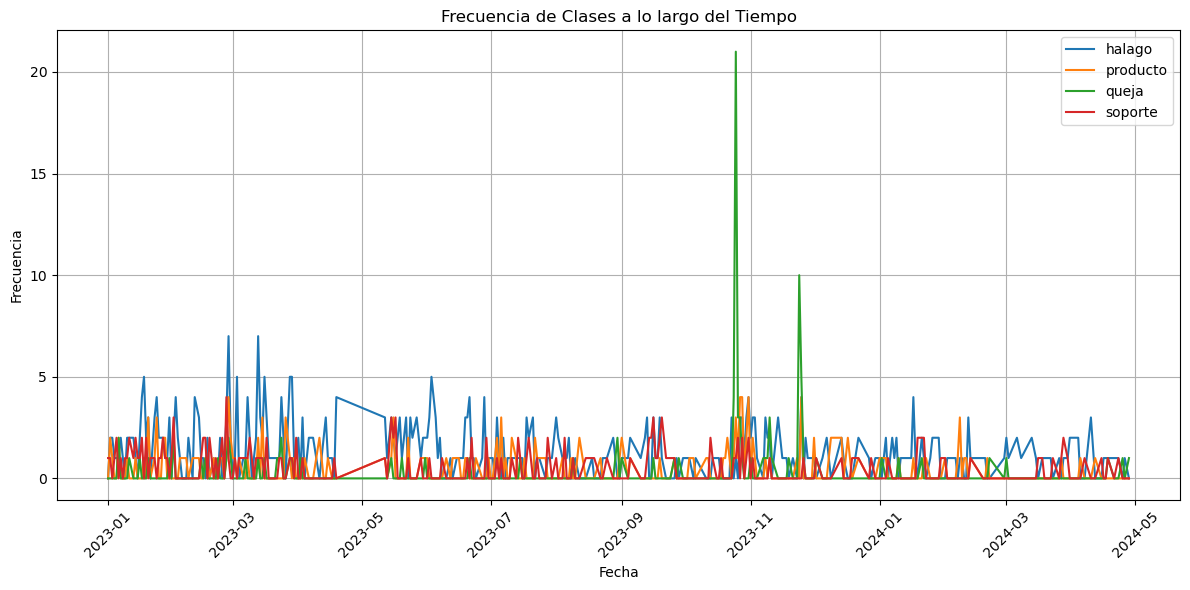

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Leer el archivo CSV con el formato de fecha especificado
df = pd.read_csv('dataset_actualizado.csv', encoding='latin1', parse_dates=['date'], dayfirst=True)


# Convertir la columna 'date' a tipo datetime
df['date'] = pd.to_datetime(df['date'])

# Agrupar por fecha y categoría, contar las ocurrencias y desapilar
df_freq = df.groupby([df['date'].dt.date, 'categoria']).size().unstack(fill_value=0)

# Graficar
plt.figure(figsize=(12, 6))

# Iterar sobre cada categoría para graficar
for category in df_freq.columns:
    plt.plot(df_freq.index, df_freq[category], label=category)

plt.title('Frecuencia de Clases a lo largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


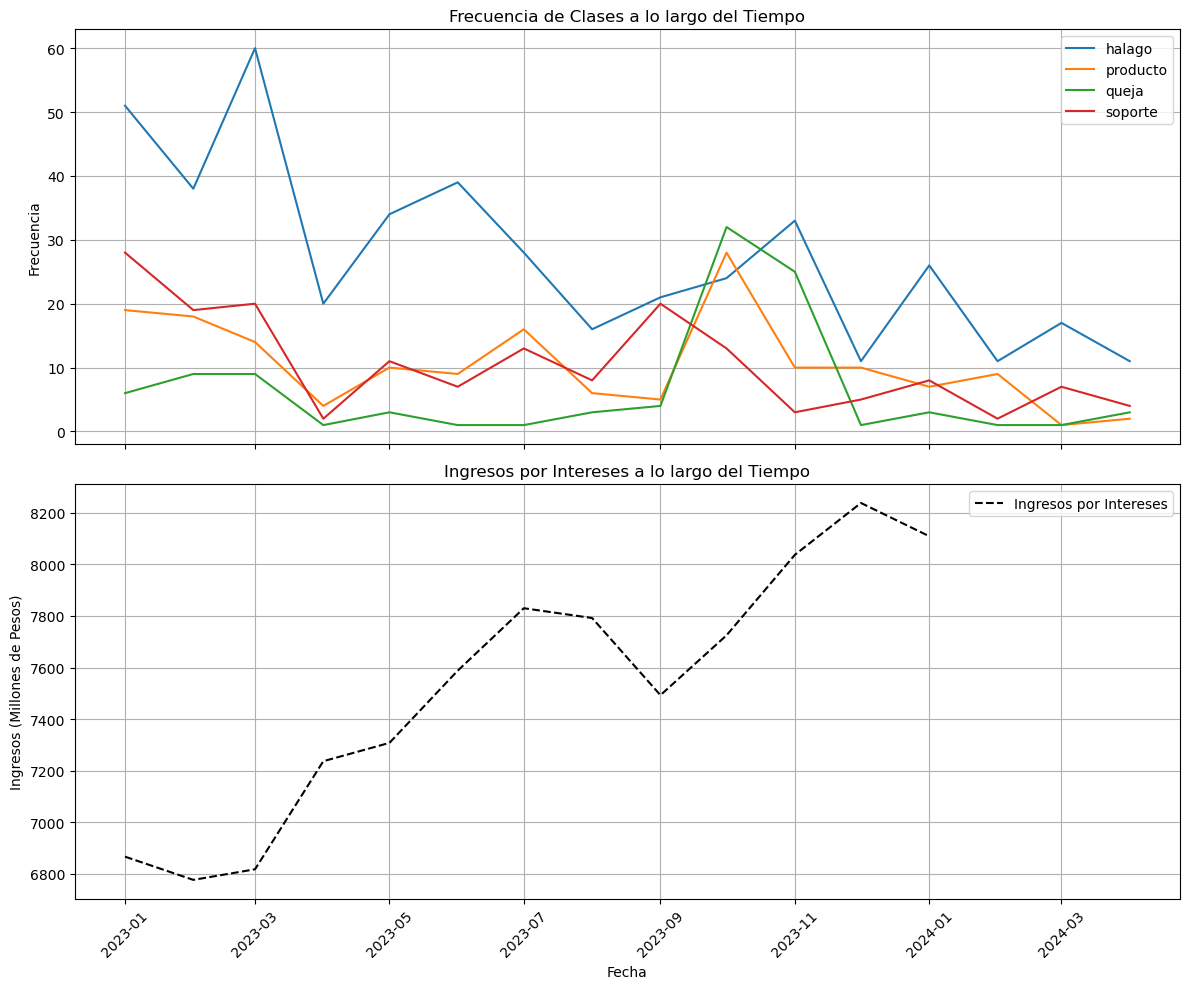

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Leer el archivo Excel con los indicadores financieros
df_indicadores = pd.read_excel("IndicadoresFin_Hey.xlsx")

# Convertir la columna 'date' a tipo datetime
df_indicadores['date'] = pd.to_datetime(df_indicadores['date'])

# Agrupar los ingresos por mes y sumarlos
df_ingresos_mes = df_indicadores.groupby(df_indicadores['date'].dt.to_period('M')).agg({'Ingresos_Interes_Millones': 'sum'})

# Suponiendo que 'df' es el DataFrame que contiene los comentarios
df_freq = df.groupby([df['date'].dt.to_period('M'), 'categoria']).size().unstack(fill_value=0)

# Crear figura y subgráficas
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Graficar frecuencia de clases
for category in df_freq.columns:
    ax1.plot(df_freq.index.to_timestamp(), df_freq[category], label=category)

# Configuraciones de la primera subgráfica
ax1.set_title('Frecuencia de Clases a lo largo del Tiempo')
ax1.set_ylabel('Frecuencia')
ax1.legend()
ax1.grid(True)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.tick_params(axis='x', rotation=45)

# Graficar ingresos
ax2.plot(df_ingresos_mes.index.to_timestamp(), df_ingresos_mes['Ingresos_Interes_Millones'], label='Ingresos por Intereses', color='black', linestyle='--')

# Configuraciones de la segunda subgráfica
ax2.set_title('Ingresos por Intereses a lo largo del Tiempo')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Ingresos (Millones de Pesos)')
ax2.legend()
ax2.grid(True)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.tick_params(axis='x', rotation=45)

# Ajustar el diseño de las subgráficas
plt.tight_layout()
plt.show()


In [11]:
import pandas as pd
import plotly.graph_objs as go
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

# Leer el archivo Excel con los indicadores financieros
df_indicadores = pd.read_excel("IndicadoresFin_Hey.xlsx")

# Convertir la columna 'date' a tipo datetime
df_indicadores['date'] = pd.to_datetime(df_indicadores['date'])

# Agrupar los ingresos por mes y sumarlos
df_ingresos_mes = df_indicadores.groupby(df_indicadores['date'].dt.to_period('M')).agg({'Ingresos_Interes_Millones': 'sum'})

# Suponiendo que 'df' es el DataFrame que contiene los comentarios
df_freq = df.groupby([df['date'].dt.to_period('M'), 'categoria']).size().unstack(fill_value=0)

# Crear la aplicación Dash
app = dash.Dash(__name__)

# Definir el diseño de la aplicación
app.layout = html.Div([
    dcc.Graph(id='graph-freq'),
    dcc.Graph(id='graph-ingresos'),
    html.Div(id='hidden-div', style={'display': 'none'}),
    html.Div([
        dcc.Checklist(
            id='category-toggle',
            options=[{'label': category, 'value': category} for category in df_freq.columns],
            value=df_freq.columns.tolist(),
            labelStyle={'display': 'inline-block'}
        )
    ])
])

# Función para actualizar el gráfico de frecuencia según las categorías seleccionadas
@app.callback(
    Output('graph-freq', 'figure'),
    [Input('category-toggle', 'value')]
)
def update_graph(selected_categories):
    traces = []

    # Agregar las líneas de frecuencia de las categorías seleccionadas
    for category in selected_categories:
        trace = go.Scatter(
            x=df_freq.index.to_timestamp(),
            y=df_freq[category],
            mode='lines',
            name=category
        )
        traces.append(trace)

    layout = go.Layout(
        title='Frecuencia de Clases a lo largo del Tiempo',
        xaxis=dict(title='Fecha'),
        yaxis=dict(title='Frecuencia'),
        legend=dict(x=0, y=-0.2),
        hovermode='closest'
    )

    return {'data': traces, 'layout': layout}

# Función para actualizar el gráfico de ingresos
@app.callback(
    Output('graph-ingresos', 'figure'),
    [Input('graph-freq', 'hoverData')]
)
def update_ingresos(hoverData):
    # Obtener la fecha seleccionada en el gráfico de frecuencia
    if hoverData is not None:
        selected_date = hoverData['points'][0]['x']
        selected_date = pd.to_datetime(selected_date)
    else:
        # Si no se ha seleccionado ninguna fecha, mostrar todos los datos
        selected_date = df_ingresos_mes.index

    # Filtrar los ingresos por intereses para la fecha seleccionada
    df_filtered_ingresos = df_ingresos_mes[df_ingresos_mes.index == selected_date]

    trace_ingresos = go.Scatter(
        x=df_filtered_ingresos.index.to_timestamp(),
        y=df_filtered_ingresos['Ingresos_Interes_Millones'],
        mode='lines',
        name='Ingresos por Intereses',
        line=dict(color='black', dash='dash')
    )

    layout = go.Layout(
        title='Ingresos por Intereses a lo largo del Tiempo',
        xaxis=dict(title='Fecha'),
        yaxis=dict(title='Ingresos (Millones de Pesos)'),
        legend=dict(x=0, y=-0.2),
        hovermode='closest'
    )

    return {'data': [trace_ingresos], 'layout': layout}

# Ejecutar la aplicación
if __name__ == '__main__':
    app.run_server(debug=True)
